# Information

- Full paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4374466/

# Libraries

1) Install Anaconda

    - Run 'brew cask install anaconda'
    - Add 'export PATH=/usr/local/anaconda3/bin:"$PATH"' to '.bash_profile' or to '.bashrc'

2) Install MNE (https://martinos.org/mne/stable/install_mne_python.html)

    - Run 'conda --version && python --version'
    - Run:
        - curl -O https://raw.githubusercontent.com/mne-tools/mne-python/master/environment.yml
        - conda env create -f environment.yml
        - source activate mne

## Load libraries

In [57]:
import mne
import scipy.io          as sio
import numpy             as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import MinMaxScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.decomposition   import PCA, FastICA
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from scipy import interp

## Config libraries

In [30]:
mne.set_log_level('INFO')

# Dataset

## Load file

In [31]:
# Load matlab file
# https://docs.scipy.org/doc/scipy/reference/tutorial/io.html
# Load the MATLAB structs as python objects rather than numpy structured arrays (struct_as_record=False)
mat = sio.loadmat('./S01.mat', struct_as_record=False, squeeze_me=True, chars_as_strings=True)

print('Loaded subject {} file'.format(mat['info'].subject))

Loaded subject 1 file


# Signals

## Load signals

- https://martinos.org/mne/stable/auto_tutorials/plot_creating_data_structures.html

In [32]:
ch_names      = mat['info'].channelnames.tolist()
ch_types      = ['eeg'] * 28 + ['eog'] * 3 # 28 EEG & 3 EOG channels
sampling_rate = mat['info'].samplingrate_Hz
# Set missing EEG montage (electrode positions)
# https://martinos.org/mne/stable/generated/mne.io.Raw.html#mne.io.Raw.set_montage
# https://mne-tools.github.io/stable/generated/mne.channels.Montage.html
# Electrodes are named and positioned according to the international 10-20 system (94+3 locations)
# https://en.wikipedia.org/wiki/10–20_system_(EEG)
montage       = 'standard_1020'

# https://martinos.org/mne/stable/generated/mne.create_info.html
sig_info = mne.create_info(ch_names, sampling_rate, ch_types, montage)

# Create MNE objects from data array
# https://martinos.org/mne/stable/auto_examples/io/plot_objects_from_arrays.html
sig_data = mat['eeg_signal']
sig_mne  = mne.io.RawArray(sig_data.T, sig_info) # https://martinos.org/mne/stable/generated/mne.io.RawArray.html
#sig_mne.pick_types(eeg=True, eog=False) # Restrict the data to the EEG channels
print('Loaded subject {} data'.format(mat['info'].subject))

Creating RawArray with float64 data, n_channels=31, n_times=1839424
    Range : 0 ... 1839423 =      0.000 ...  3592.623 secs
Ready.
Loaded subject 1 data


In [33]:
print('Data from subject {}'.format(mat['info'].subject))
print(sig_info)
print(sig_mne)

Data from subject 1
<Info | 17 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | FPZ, AFZ, F3, FZ, F4, F8, FC3, FCZ, FC4, ...
    chs : list | 31 items (EEG: 28, EOG: 3)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 31 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 256.0 Hz
    nchan : int | 31
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 512.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_date : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    su

### Set EEG reference

In [34]:
# TODO: Consultar la referencia?
# Setting EEG reference
# https://martinos.org/mne/dev/auto_tutorials/plot_eeg_erp.html#setting-eeg-reference
# Remove the reference
# This explicitly prevents MNE from adding a default EEG average reference required for source localization.
#sig_mne_no_ref, _ = mne.set_eeg_reference(sig_mne, [])

## Sensors

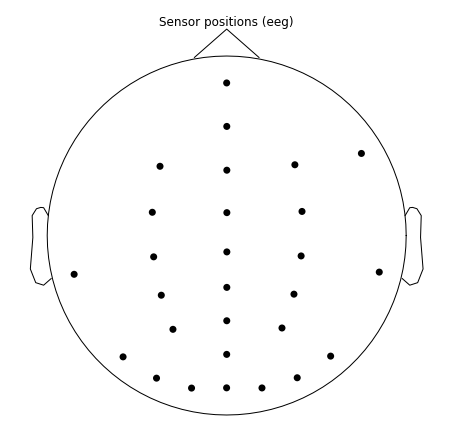

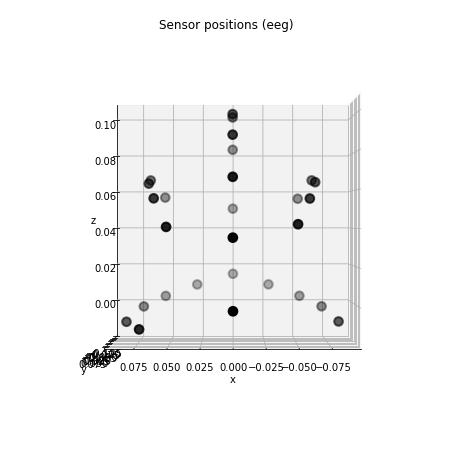

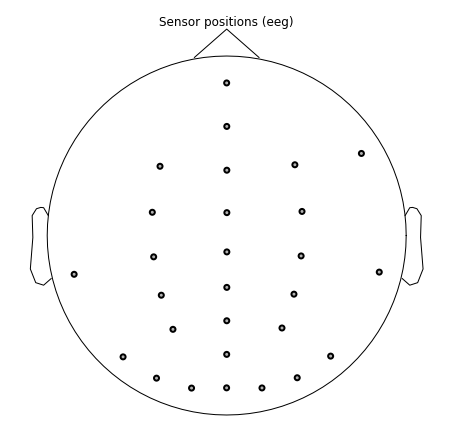

(<Figure size 432x432 with 1 Axes>, [])

In [35]:
# Plot sensors
sig_mne.plot_sensors()
sig_mne.plot_sensors('3d') # in 3D
sig_mne.plot_sensors('select')

## Plot signals

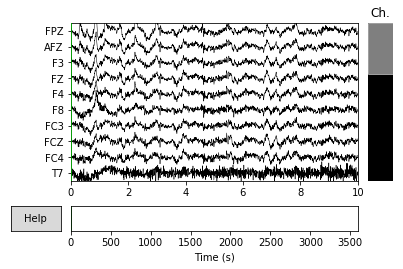

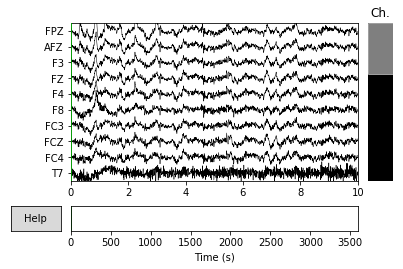

In [36]:
# Plot raw data of first 10 channels
sig_mne.plot(n_channels=10, scalings='auto', block=True)

Effective window size : 4.000 (s)


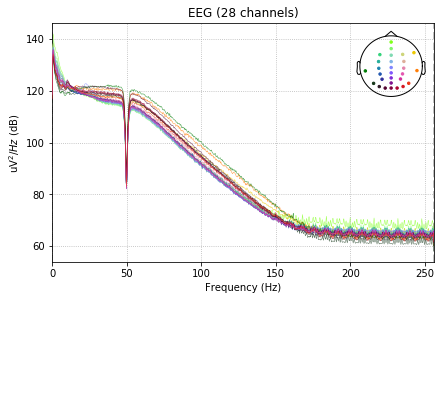

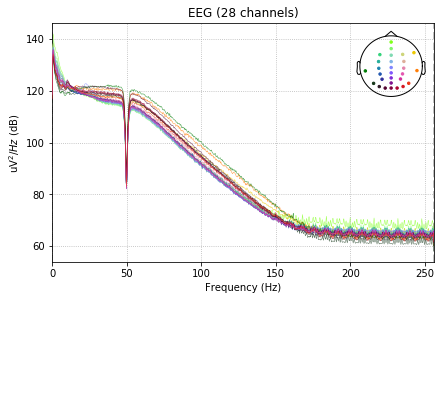

In [37]:
# Compute the power spectral density of raw data
# https://martinos.org/mne/stable/auto_examples/time_frequency/plot_compute_raw_data_spectrum.html
sig_mne.plot_psd()

Setting up band-pass filter from 1 - 20 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 1691 samples (3.303 sec) selected
Effective window size : 4.000 (s)


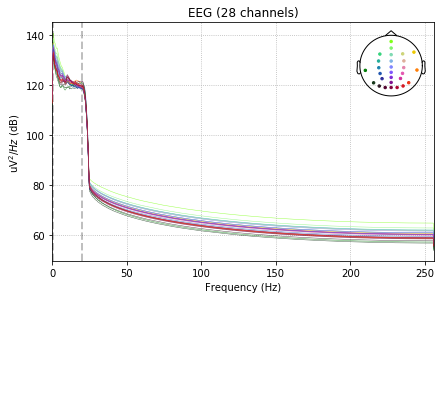

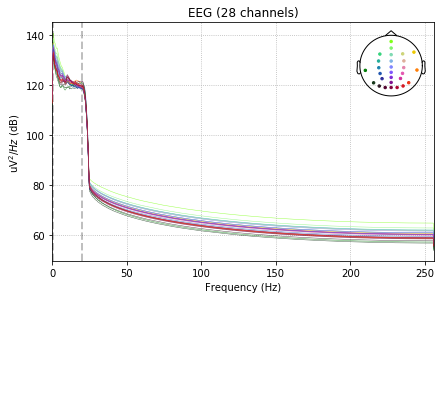

In [38]:
# Band-pass filter data
sig_mne.filter(l_freq=1.0, h_freq=20.0)

# Plot the power spectral density across filtered channels
sig_mne.plot_psd()

In [39]:
# start, stop = raw.time_as_index([100, 115])  # 100 s to 115 s data segment
# data, times = raw[:, start:stop]
# print(data.shape)
# print(times.shape)
# data, times = raw[2:20:3, start:stop]  # access underlying data
# raw.plot()

# Events

## Load events

- https://martinos.org/mne/stable/auto_tutorials/plot_creating_data_structures.html
- https://martinos.org/mne/stable/auto_examples/io/plot_read_events.html#ex-read-events

In [40]:
# Adds event channel with angle values
ee_ch_name  = 't_type'
ee_ch_type  = 'misc'
ee_tmin     = 0.0
ee_tmax     = 2.0

# Create info
sig_events_info = mne.create_info(
    ch_names = ch_names + [ee_ch_name],
    ch_types = ch_types + [ee_ch_type],
    sfreq    = sampling_rate,
    montage  = 'standard_1020'
)

# Create raw
ee_angles_data  = mat['marker'].execution_error_angle
ee_angles_id    = list(set(ee_angles_data) - {0}) # list of event values
sig_events_data = np.c_[sig_data, ee_angles_data] # https://stackoverflow.com/q/20978757/3349531
sig_events_mne  = mne.io.RawArray(sig_events_data.T, sig_events_info)

print('Events values = {}'.format(ee_angles_id))

Creating RawArray with float64 data, n_channels=32, n_times=1839424
    Range : 0 ... 1839423 =      0.000 ...  3592.623 secs
Ready.
Events values = [45, 270, 180, 90, 315]


In [41]:
# Find events
# https://martinos.org/mne/stable/generated/mne.find_events.html
ee_events = mne.find_events(sig_events_mne, stim_channel=ee_ch_name)

520 events found
Event IDs: [ 45  90 180 270 315]


In [42]:
# Find epochs
sig_events_epochs = mne.Epochs(sig_mne, ee_events, ee_angles_id, tmin=ee_tmin, tmax=ee_tmax)

print('Loaded (#Epochs, #Channels, #Times) = {}'.format(sig_events_epochs.get_data().shape))

520 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 520 events and 1025 original time points ...
0 bad epochs dropped
Loaded (#Epochs, #Channels, #Times) = (520, 31, 1025)


## Plot events

- https://martinos.org/mne/stable/auto_tutorials/plot_visualize_epochs.html

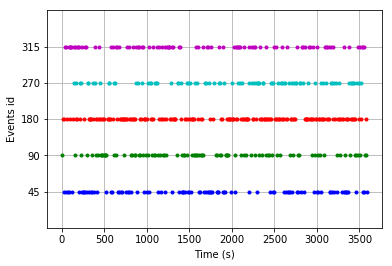

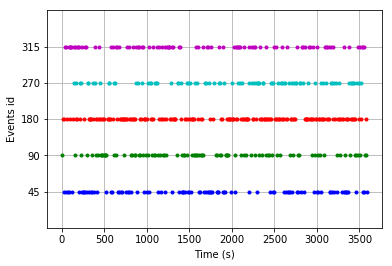

In [43]:
# Plot all events
mne.viz.plot_events(ee_events, sfreq=sampling_rate) # https://martinos.org/mne/stable/generated/mne.viz.plot_events.html

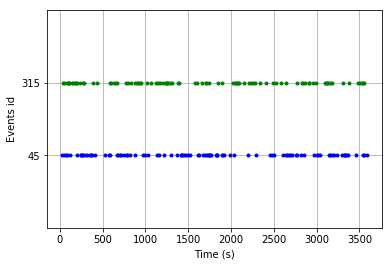

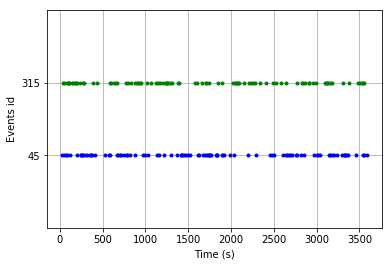

In [44]:
# Plot [45, 315] events
ee_events_45_270 = mne.pick_events(ee_events, include=[45, 315])
mne.viz.plot_events(ee_events_45_270, sfreq=sampling_rate)

## Plot epochs

https://martinos.org/mne/stable/auto_tutorials/plot_visualize_epochs.html

Loading data for 393 events and 1025 original time points ...
Loading data for 20 events and 1025 original time points ...


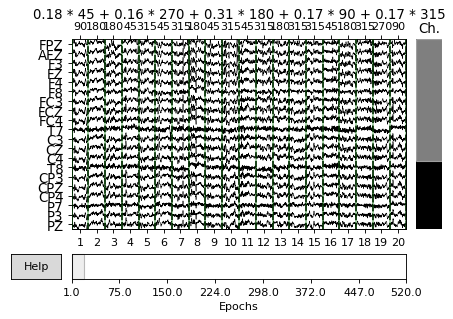

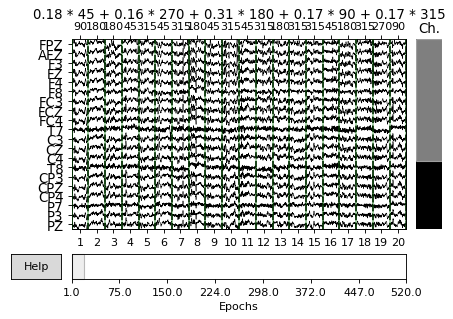

In [45]:
sig_events_epochs.plot(scalings='auto', block=True)

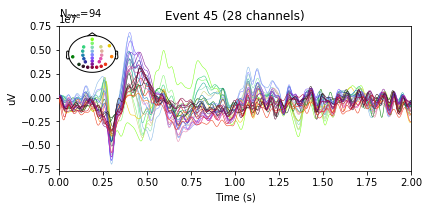

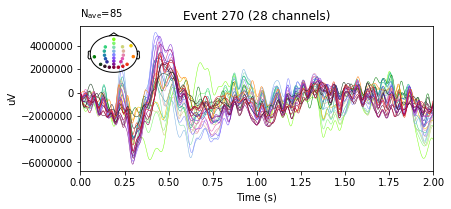

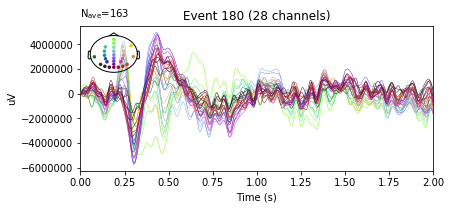

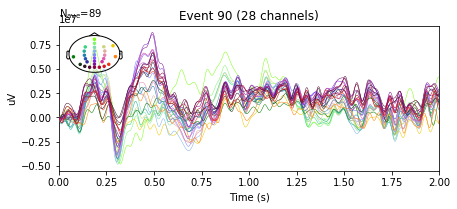

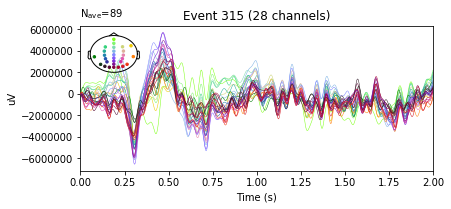

In [46]:
# Plot average for each event type
for each in ee_angles_id:
    event_type = str(each)
    sig_events_epochs[event_type].average().plot(titles=('Event ' + event_type), time_unit='s', spatial_colors=True)

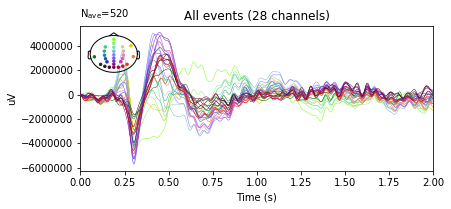

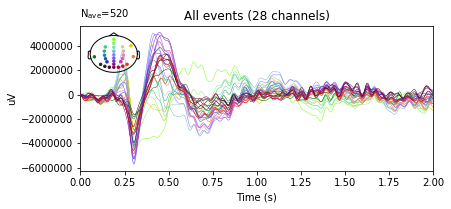

In [47]:
# Plot average for all types
sig_events_epochs.average().plot(titles=('All events'), time_unit='s', spatial_colors=True)

# Analisys

## Load data

In [48]:
target_names = ['nohit', 'hit']

# Create raw
ee_hits_data  = mat['marker'].execution_error
ee_hits_id    = list(set(ee_hits_data)) # list of event values
sig_hits_data = np.c_[sig_data, ee_hits_data] # https://stackoverflow.com/q/20978757/3349531
sig_hits_mne  = mne.io.RawArray(sig_hits_data.T, sig_events_info)

print('Events values = {}'.format(ee_hits_id))

# Find events
ee_hits = mne.find_events(sig_hits_mne, stim_channel=ee_ch_name, output='step', initial_event=True, consecutive=True)

# Find epochs
hits_epochs        = mne.Epochs(sig_mne, ee_hits, ee_hits_id, tmin=ee_tmin, tmax=ee_tmax, proj=False, baseline=None, preload=True)
hits_epochs_labels = hits_epochs.events[:, -1]

print('Loaded (#Epochs, #Channels, #Times) = {}'.format(hits_epochs.get_data().shape))

Creating RawArray with float64 data, n_channels=32, n_times=1839424
    Range : 0 ... 1839423 =      0.000 ...  3592.623 secs
Ready.
Events values = [0, 1]
1040 events found
Event IDs: [0 1]
1040 matching events found
No baseline correction applied
Not setting metadata
Loading data for 1040 events and 1025 original time points ...
0 bad epochs dropped
Loaded (#Epochs, #Channels, #Times) = (1040, 31, 1025)


## Train

- http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
- http://scikit-learn.org/stable/tutorial/basic/tutorial.html

In [49]:
def cross_val(classifier, cross_validator, epochs, hits_epochs_labels):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0

    plt.figure(figsize=(20, 10))
    # Do cross-validation
    for train_index, test_index in cross_validator.split(epochs, hits_epochs_labels):
#         print(train_index)
#         print(test_index)
        data_train, data_test = epochs[train_index], epochs[test_index]
        labels_train, labels_test = hits_epochs_labels[train_index], hits_epochs_labels[test_index]
        classifier_fit = classifier.fit(data_train, labels_train)
        
        prediction = classifier_fit.predict(data_test)
        prediction_proba = classifier_fit.predict_proba(data_test)
        print("Accuracy of iteration {}: {}".format(i, accuracy_score(labels_test, prediction)))
        # ROC curve for fold i
        # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
        fpr, tpr, thresholds = roc_curve(labels_test, prediction_proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        

    # Chance line
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    # Mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    # Std. dev. ROC
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    # Plot ROC
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.xlim([-0.05, 1.05])
    plt.ylabel('True positive radte')
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="best")
    plt.show()

In [60]:
def print_confusion_matrix(classifier, data_test, labels_test, cross_validator=None):
    if cross_validator is None:
        predictions = classifier.predict(data_test)
    else:
        predictions = cross_val_predict(classifier, data_test, hits_epochs_labels, cv=cross_validator)
    confusion_m = confusion_matrix(hits_epochs_labels, predictions)
    
    # Classification report
    report = classification_report(hits_epochs_labels, predictions, target_names=target_names)
    print(report)
    
    print("Confusion matrix")
    print(confusion_m)

    # Normalized confusion matrix
    confusion_m_norm = confusion_m.astype(float) / confusion_m.sum(axis=1)[:, np.newaxis]

    # Plot it
    plt.imshow(confusion_m_norm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(target_names))
    plt.title('Normalized Confusion matrix')
    plt.xlabel('Predicted label')
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.ylabel('True label')
    plt.yticks(tick_marks, target_names)
    plt.clim(0,1)
    plt.colorbar()
    mne.viz.tight_layout()
    plt.show()

C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of iteration 0: 0.6442307692307693


C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of iteration 1: 0.6538461538461539


C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of iteration 2: 0.7403846153846154


C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of iteration 3: 0.6346153846153846


C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of iteration 4: 0.5192307692307693


C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of iteration 5: 0.7211538461538461


C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of iteration 6: 0.6538461538461539


C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of iteration 7: 0.75


C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of iteration 8: 0.5576923076923077


C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of iteration 9: 0.625


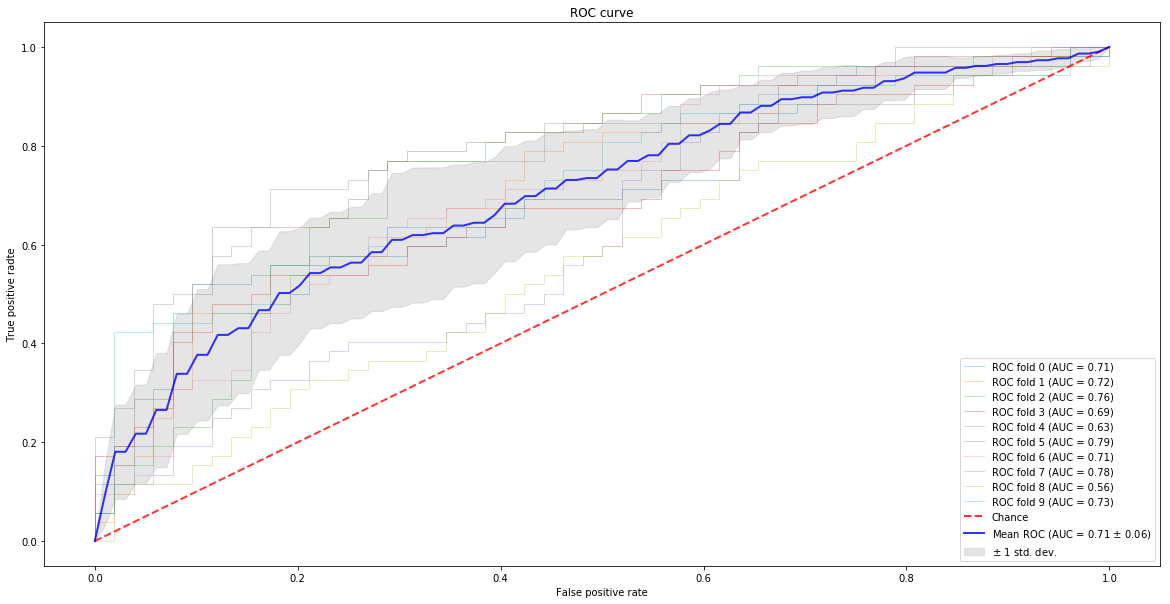

C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jose_\Anaconda3\envs\mne\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to '

              precision    recall  f1-score   support

       nohit       0.65      0.66      0.65       520
         hit       0.65      0.64      0.65       520

   micro avg       0.65      0.65      0.65      1040
   macro avg       0.65      0.65      0.65      1040
weighted avg       0.65      0.65      0.65      1040

Confusion matrix
[[345 175]
 [189 331]]


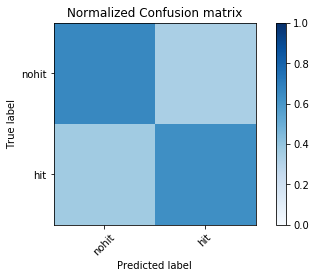

In [61]:
classifier = make_pipeline(
    mne.decoding.Vectorizer(),  # Transform n-dimensional array into 2D array of n_samples by n_features.
    MinMaxScaler(),  # Transforms features by scaling each feature to a given range (0, 1).
    LogisticRegression()  # linear model for classification
#     SGDClassifier(loss='modified_huber')
#     linear_model.BayesianRidge()
#     KNeighborsClassifier(n_neighbors=8)
    
)
# Set cross-validator
# Stratified K-Folds cross-validator
# Provides train/test indices to split data in train/test sets
# This cross-validation object is a variation of KFold that returns stratified folds
# Stratification is done based on the labels provided in split(_, labels)
# The folds are made by preserving the percentage of samples for each class
# https://machinelearningmastery.com/k-fold-cross-validation/
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
epochs = hits_epochs.get_data()[:,:7,:]
cross_validator = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cross_val(classifier, cross_validator, epochs, hits_epochs_labels)
print_confusion_matrix(classifier, epochs, hits_epochs_labels, cross_validator=cross_validator)